In [ ]:
pip install wandb -q

In [ ]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:35703")

# Import

In [ ]:
import numpy as np
import xarray as xr
import torch
import pytorch_lightning as pl
from scipy import ndimage
import itertools
import os
from pytorch_lightning.loggers import WandbLogger
import wandb
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,Callback
import myParam
import matplotlib.pyplot as plt

In [ ]:
import platform
print(platform.platform())

In [ ]:
print(torch.__version__)

In [ ]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")

In [ ]:
import importlib

In [ ]:
importlib.reload(myParam)

## Open data

In [ ]:
PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET'] 

In [ ]:
data_dict=[dict() for i in range(6)]
data_dict[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GULFSTR FMA'})
data_dict[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GULFSTR ASO'})
data_dict[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'MIDATL FMA'})
data_dict[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'MIDATL ASO'})
data_dict[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'WESTMED FMA'})
data_dict[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'WESTMED ASO'})

In [ ]:
batch_size = 4
height = 45
width = 40

In [ ]:
%%time
features_to_add_to_sample = ['temp', 'temp_var', 'rho_ct_ct', 'diff_temp_sqr']
auxiliary_features = ['z_l', 'f', 'e1t', 'e2t']
all_data_3D = myParam.PyLiDataModule(data_dict, '3D', features_to_add_to_sample, auxiliary_features, height, width, batch_size=batch_size)

In [ ]:
%%time
features_to_add_to_sample = ['temp', 'temp_var', 'rho_ct_ct', 'diff_temp_sqr']
auxiliary_features = ['e1t', 'e2t']
all_data_2D = myParam.PyLiDataModule(data_dict, '2D', features_to_add_to_sample, auxiliary_features, height, width, batch_size=batch_size)

# Run experiment routine

In [ ]:
class LogPredictionsCallback(Callback):
    def __init__(self, logger, feature) :
        super().__init__()
        self.logger = logger
        self.feature = feature
    
    def on_predict_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx):
        if (batch_idx == 0):
            index_sample = 0
            if ('temp_var_masked' in outputs.keys()) :
                if (len(outputs['temp_var_masked'].shape) == 3) :
                    truth = batch['temp_var'][index_sample,:,:].cpu()
                    prediction = outputs['temp_var_masked'][index_sample,:,:].cpu()
                if (len(outputs['temp_var_masked'].shape) == 4) :
                    truth = batch['temp_var'][index_sample,0,:,:].cpu()
                    prediction = outputs['temp_var_masked'][index_sample,0,:,:].cpu()
            fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(5.,2.5),sharex=True, sharey=True)
            img = ax[0].imshow(truth, cmap='ocean_r', origin='lower')
            fig.colorbar(img, location='left', shrink=0.8)
            ax[0].set(title='Truth')
            color_min = img.colorbar.vmin
            color_max = img.colorbar.vmax
            current_cmap = img.cmap
            current_cmap.set_bad(color='silver')
            ax[1].imshow(prediction, cmap=current_cmap, \
                         vmin=color_min, vmax=color_max, origin='lower')
            ax[1].set(title='Prediction')
            fig.savefig('logs/figure.png')
            self.logger.log_image(key="Example "+str(dataloader_idx), images=[wandb.Image("logs/figure.png")], \
                                  step=None)

In [ ]:
def run_experiment(config, project) :
    wandb_logger = WandbLogger(name=config['model_label']+'_'+config['version'], \
                               version=config['model_label']+'_'+config['version'],\
                               project=project, config=config, resume=False, log_model=True, offline=False)
    
    torch_model = eval(config['torch_model'])(**config['torch_model_params'])
    pylight_module = myParam.GenericPyLiModule(torch_model, **config['module_params'])
    
    # Callbacks
    checkpoint_callback = ModelCheckpoint(monitor="loss_train", save_last=True)    
    early_stopping_callback = EarlyStopping(monitor="loss_validation", mode="min")
    log_predictions_callback = LogPredictionsCallback(wandb_logger, config['module_params']['output_features'][0])
    
    trainer = pl.Trainer(**config['training_params'], logger=wandb_logger, 
                     callbacks=[early_stopping_callback, checkpoint_callback,log_predictions_callback],
                     accelerator='gpu', devices=(1 if torch.cuda.is_available() else None))  
    trainer.fit(model = pylight_module, datamodule=eval(config['datamodule']))
    #perform tests
    test_datamodule = eval(config['datamodule'])
    test_datamodule.setup(stage='test')
    trainer.predict(model = pylight_module, dataloaders=test_datamodule.test_dataloader())
    test_datamodule.setup(stage='test')
    trainer.test(model = pylight_module, datamodule=test_datamodule)
    wandb.finish()

# Runs

In [ ]:
wandb.finish()

In [ ]:
project_name = 'tests'

In [ ]:
configs = list()

## Linear regression

In [ ]:
configs.append(dict({'model_label' : 'LinReg',
                'version' : 'HuberLoss2D_nn',
                'torch_model' : 'myParam.lin_regr_model',
                'datamodule' : 'all_data_2D',
                'torch_model_params' : dict({'data_geometry' : '2D',\
                                            'nb_of_input_features' : 1, \
                                            'nb_of_output_features' : 1}),
                'module_params' : dict({'input_features'  : ['diff_temp_sqr'],
                                        'output_features'  : ['temp_var'],
                                        'output_units' : None,
                                        'loss' : torch.nn.functional.huber_loss,
                                        'optimizer' : torch.optim.SGD,
                                        'learning_rate' : 1e-3,
                                        'loss_normalization' : False}),
                'training_params' : dict({'max_epochs' : 100,
                                          'limit_train_batches' : 1.0})
               }))
run_experiment(configs[-1], project_name)

## FCNN

In [ ]:
configs.append(dict({'model_label' : 'FCNN',
                'version' : '3D_patch3-3_MSELoss_inNorm_outnondim',
                'torch_model' : 'myParam.FCNN',
                'datamodule' : 'all_data_3D',
                'torch_model_params' : dict({'data_geometry' : '3D',\
                                            'nb_of_input_features' : 1, \
                                            'nb_of_output_features' : 1, \
                                            'input_patch_size' : 3,
                                            'output_patch_size' : 3, 
                                            'int_layer_width' : 50}),
                'module_params' : dict({'input_features'  : ['temp'],
                                        'output_features'  : ['temp_var'],
                                        'output_units' : ['diff_temp_sqr'],
                                        'input_normalization_features' : ['sqrt_filtered_diff_temp_sqr'],
                                        'loss' : torch.nn.functional.mse_loss,
                                        'optimizer' : torch.optim.Adam,
                                        'learning_rate' : 1e-4,
                                        'loss_normalization' : False}),
                'training_params' : dict({'max_epochs' : 100,
                                          'limit_train_batches' : 1.0})
               }))
run_experiment(configs[-1], project_name)

## CNN

In [ ]:
configs.append(dict({'model_label' : 'CNN',
                'version' : 'kernel3_MSELossNorm_inNorm_outnondim',
                'torch_model' : 'myParam.CNN',
                'datamodule' : 'all_data_3D',
                'torch_model_params' : dict({'data_geometry' : '3D',\
                                            'nb_of_input_features' : 1, \
                                            'nb_of_output_features' : 1, \
                                            'kernel_size' : 3,
                                            'int_layer_width' : 64}),
                'module_params' : dict({'input_features'  : ['temp'],
                                        'output_features'  : ['temp_var'],
                                        'output_units' : ['diff_temp_sqr'],
                                        'input_normalization_features' : ['sqrt_filtered_diff_temp_sqr'],
                                        'loss' : torch.nn.functional.mse_loss,
                                        'optimizer' : torch.optim.Adam,
                                        'learning_rate' : 1e-3,
                                        'loss_normalization' : True}),
                'training_params' : dict({'max_epochs' : 100,
                                          'limit_train_batches' : 1.0})
               }))
run_experiment(configs[-1], project_name)

# Load last checkpoints

Load from wandb the models with the weights:

In [ ]:
api = wandb.Api()

In [ ]:
list_of_models = [dict() for i in range(len(list_of_configs))]

In [ ]:
for i, config in enumerate(list_of_configs) : 
    checkpoint_reference = 'anagorb63/'+project_name+"/model-"+config['model_label']+'_'+config['version']+':v0'
    artifact = api.artifact(checkpoint_reference)
    artifact_dir = artifact.download()
    list_of_models[i]['best'] = myParam3Ddata.GenericPyLiModule.load_from_checkpoint(os.path.abspath(artifact_dir)+"/model.ckpt")
    list_of_models[i]['label'] = config['model_label']+'_'+config['version']
    list_of_models[i]['model_name'] = config['model_label']
    list_of_models[i]['version'] = config['version']

# Get predictions

In [40]:
%%time
test_datamodule = all_data
test_datamodule.setup(stage='test')

CPU times: user 349 µs, sys: 0 ns, total: 349 µs
Wall time: 95.8 µs


In [ ]:
%%time
for i, model in enumerate(list_of_models) :
    trainer = pl.Trainer(accelerator='gpu', devices=1)
    model['pred'] = dict()
    prediction_dict = trainer.predict(model['best'], dataloaders=test_datamodule.test_dataloader())
    for feature in list(prediction_dict[0][0].keys()) :
        model['pred'][feature] = [prediction_dict[idx_dataset][0][feature] for idx_dataset in range(len(test_datamodule.test_dataloader()))]
    del prediction_dict

# Get ground truth

In [42]:
truth = dict()
for feature in ['votemper_var', 'rho_ct_ct', 'f', 'e1t', 'e2t'] :
    truth[feature] = [torch.Tensor() for i in range(len(test_datamodule.test_dataloader()))]

In [43]:
for i, dataloader in enumerate(test_datamodule.test_dataloader()) :
    iterator = iter(dataloader)
    sample = next(iterator)
    for feature in ['votemper_var', 'rho_ct_ct', 'e1t', 'e2t'] :
        if (len(sample[feature].shape) == 4) :
            truth[feature][i] = sample[feature].where(sample['mask'][:,None,:,:], torch.ones_like(sample['mask'][:,None,:,:])*np.nan)
        if (len(sample[feature].shape) == 3) :
            truth[feature][i] = sample[feature].where(sample['mask'], torch.ones_like(sample['mask'])*np.nan)        

# Get logged metrics

In [44]:
metrics_list = ['loss_val', 'loss_grad', 'corr_coef', 'corr_coef_grad']

In [45]:
feature_list = ['votemper_var']

In [46]:
for i, model in enumerate(list_of_models) : 
    run_id = model['label']
    run = api.run("anagorb63/"+project_name+"/"+run_id)
    metrics_table = run.history().iloc[-1]
    for feature in feature_list :
        model[feature] = dict()
        for metrics in metrics_list :
            model[feature][metrics] = [metrics_table[metrics+'_'+feature+'/dataloader_idx_'+str(idx)] for idx in range(len(test_datamodule.test_dataloader()))]
    model['pressure_grad'] = dict()
    model['pressure_grad']['loss_val'] = [metrics_table['loss_val_pressure_grad/dataloader_idx_'+str(idx)] for idx in range(len(test_datamodule.test_dataloader()))]

# Image examples

In [47]:
def plot_snapshots_at_2depths(idx_batch, idx_levels, idx_region, feature) : 
    fig, axs = plt.subplots(nrows=2, ncols=1, constrained_layout=True, figsize=(2*(len(list_of_models)+1),5),sharex=True, sharey=True)
    fig.suptitle('Snapshots in ' + data_dict[idx_region]['label'])

    # clear subplots
    for ax in axs:
        ax.remove()

    # add subfigure per subplot
    gridspec = axs[0].get_subplotspec().get_gridspec()
    subfigs = [fig.add_subfigure(gs) for gs in gridspec]

    for row, subfig in enumerate(subfigs):
        axs = subfig.subplots(ncols=len(list_of_models)+1, nrows=1, sharex=True, sharey=True)
        img = axs[0].imshow(truth[feature][idx_region][idx_batch,idx_levels[row],:,:], \
                            cmap=('ocean_r' if (row==0) else current_cmap), \
                            #vmin=(None if (row==0) else color_min), vmax=(None if (row==0) else color_max), \
                            origin='lower')
        fig.colorbar(img, location='left',  shrink=0.8)
        axs[0].set(title='Truth')
        #if (row == 0) :
        color_min = img.colorbar.vmin
        color_max = img.colorbar.vmax
        current_cmap = img.cmap
        current_cmap.set_bad(color='silver')

        for i, model in enumerate(list_of_models) :
            img = axs[i+1].imshow(model['pred'][feature + '_masked'][idx_region][idx_batch,idx_levels[row],:,:], cmap=current_cmap, \
                                           vmin=color_min, vmax=color_max, origin='lower')
            axs[i+1].set(title=model['label'])
        fig.colorbar(img, ax=axs[-1], shrink=0.8)
    subfigs[0].suptitle('On the surface')
    subfigs[1].suptitle('At depth')
    plt.show()

In [48]:
idx_batch = 0

In [49]:
idx_levels = [0,106]

## Region 1 : Gulfstream (FMA)

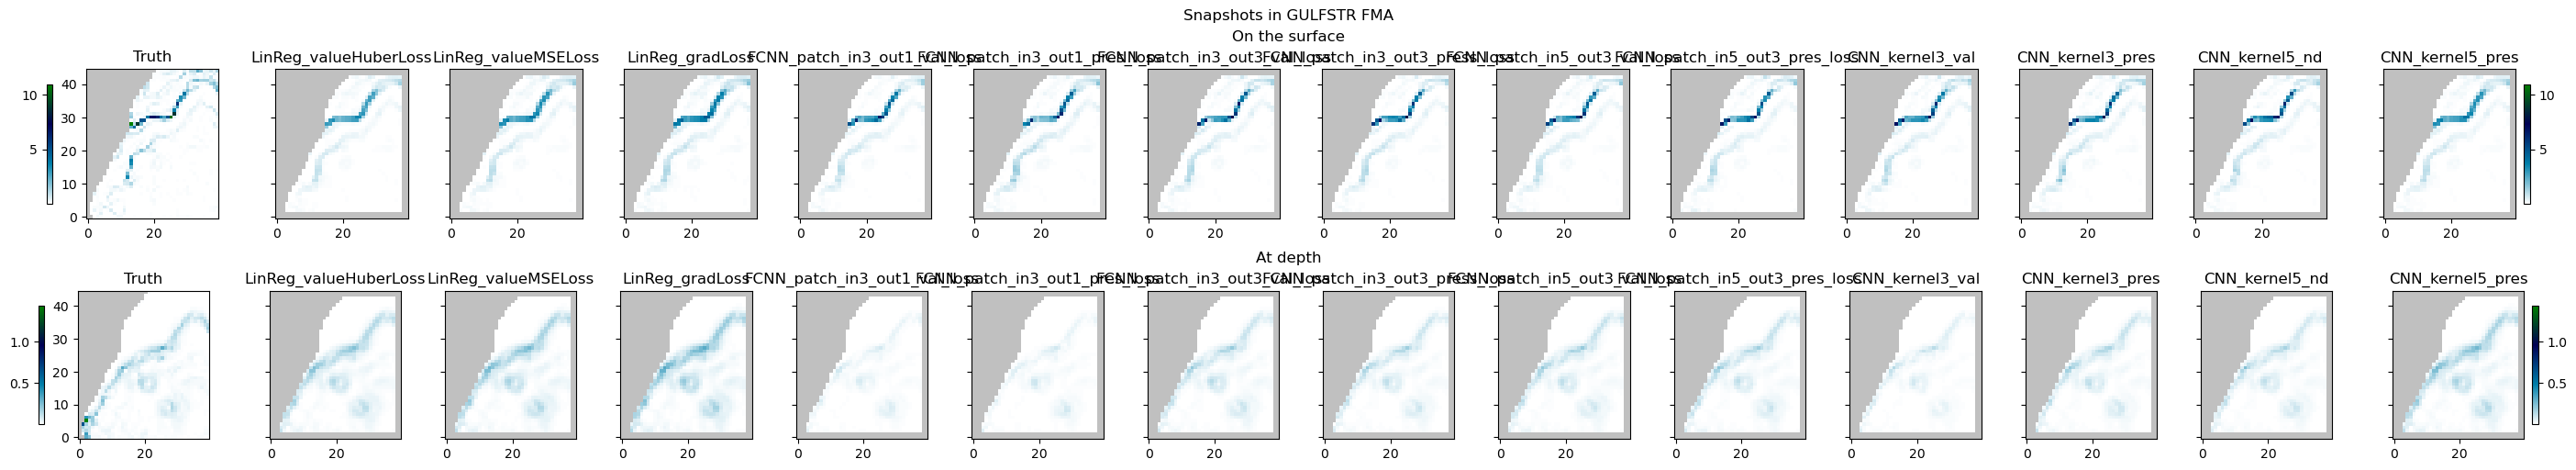

In [50]:
idx_region = 0

plot_snapshots_at_2depths(idx_batch, idx_levels, idx_region, 'votemper_var')

## Region 2 - Mid Atlantic (ASO)

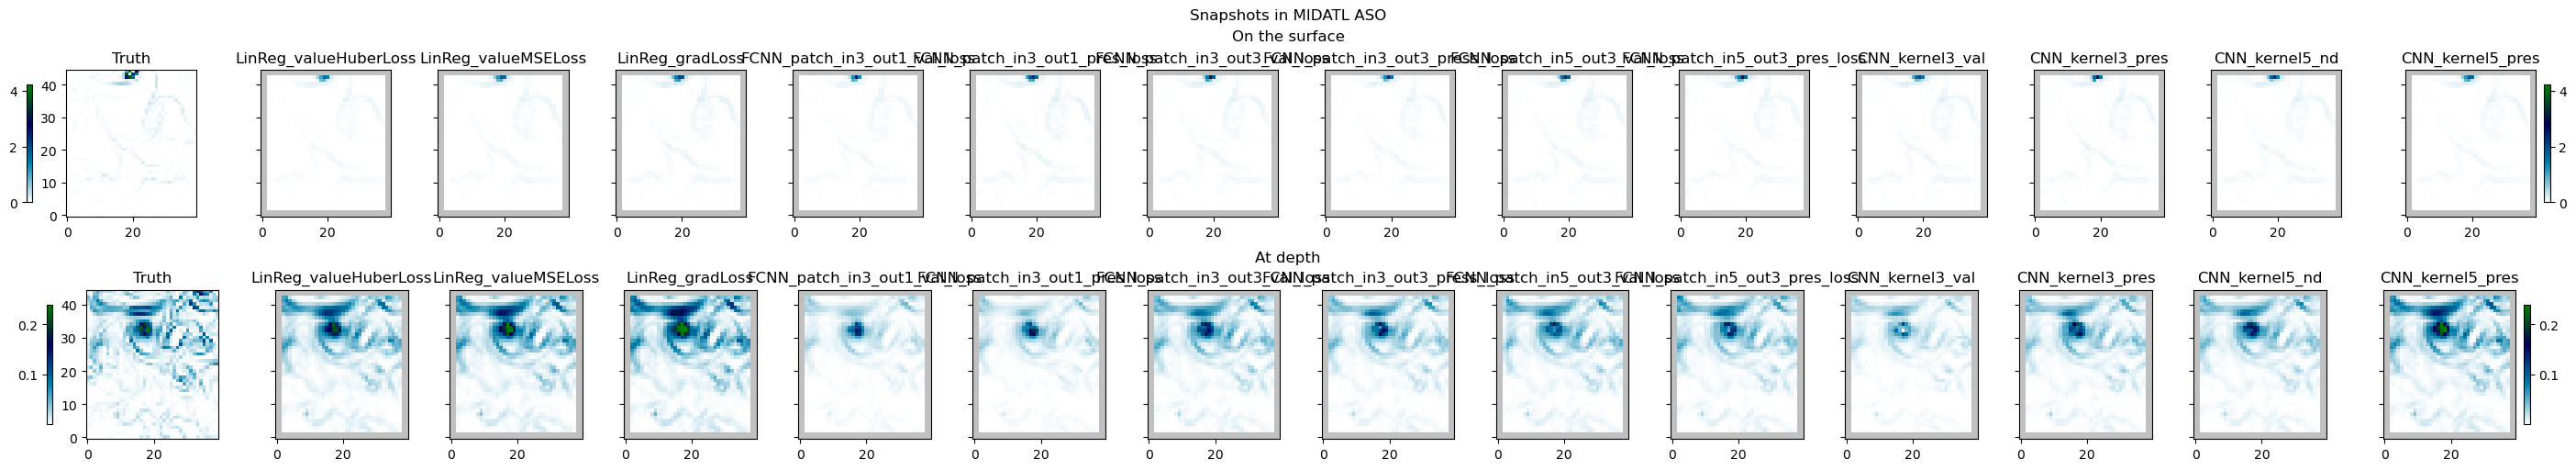

In [51]:
idx_region = 3

plot_snapshots_at_2depths(idx_batch, idx_levels, idx_region, 'votemper_var')

## Region 3 - WEDMED (ASO)

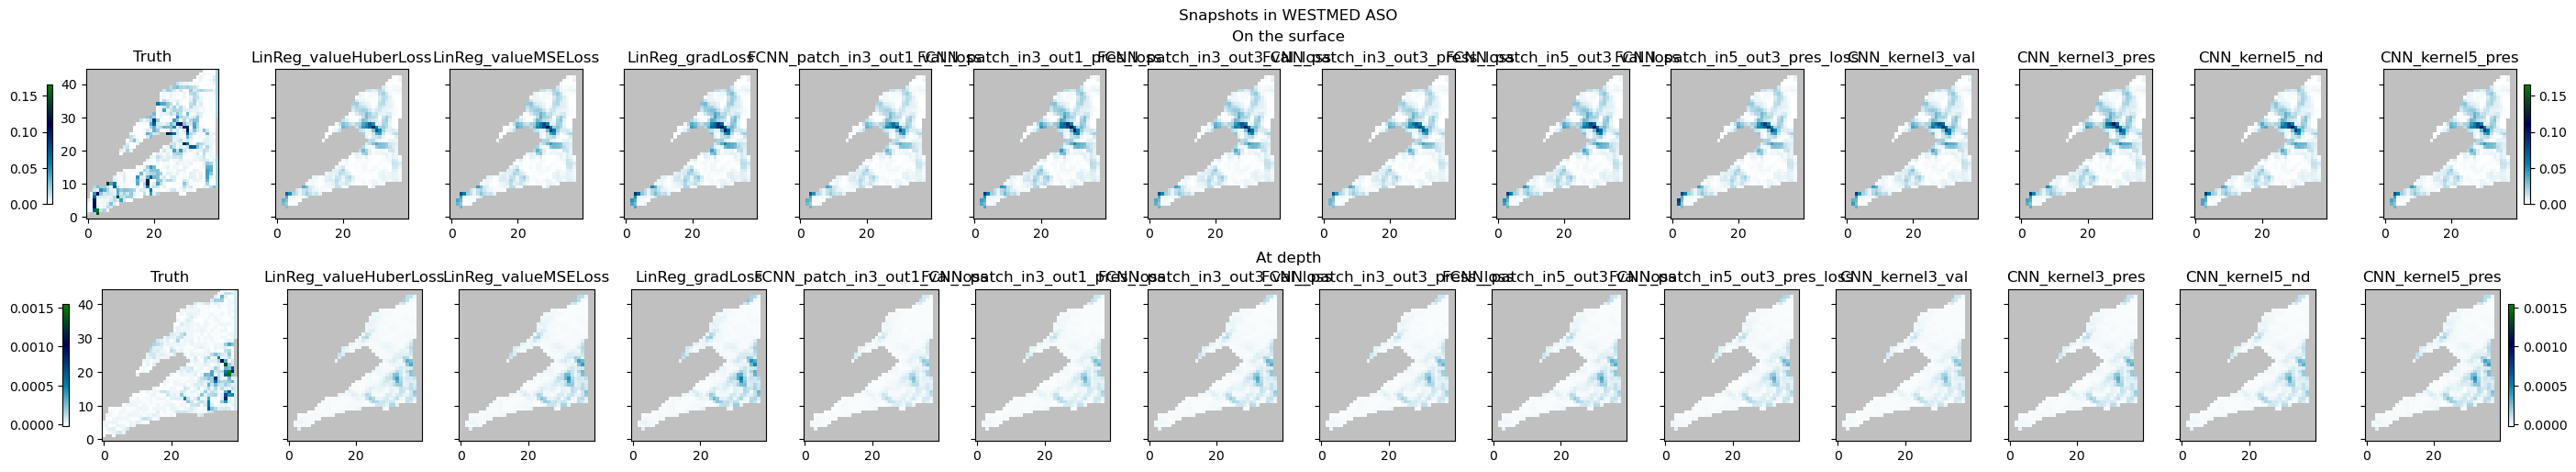

In [52]:
idx_region = 5

plot_snapshots_at_2depths(idx_batch, idx_levels, idx_region, 'votemper_var')

# Metrics over all datasets

In [53]:
bar_colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.BASE_COLORS.values())

In [54]:
xlabels = ['LinReg', 'FCNN', 'CNN']

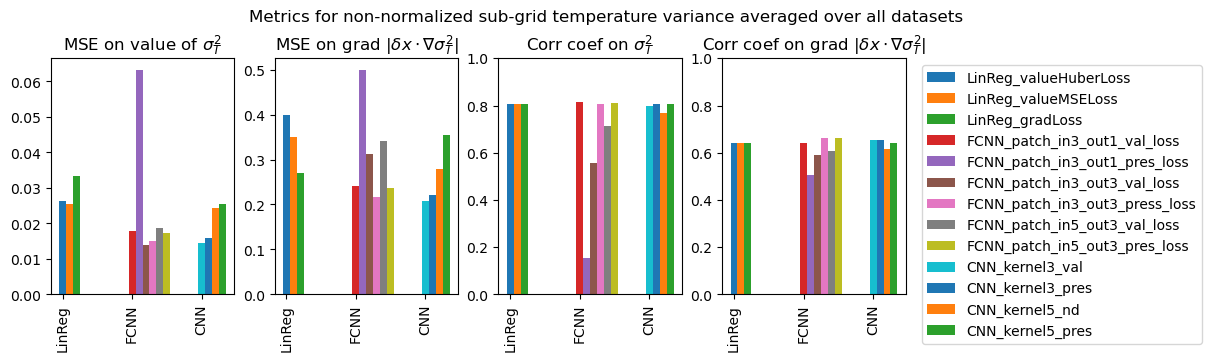

In [55]:
fig, ax = plt.subplots(1, len(metrics_list), constrained_layout=True, figsize=(3.0*len(metrics_list), 3.5), sharex=True)
fig.suptitle('Metrics for non-normalized sub-grid temperature variance averaged over all datasets')
x = np.arange(3)
versions = [0 for i in x]
bar_width = 0.1
feature = 'votemper_var'
for idx_model, model in enumerate(list_of_models) :
    i = xlabels.index(model['model_name'])
    j = versions[i]
    for idx, metrics in enumerate(metrics_list) :
        ax[idx].bar(x[i]+j*bar_width, np.mean(model[feature][metrics]), width=bar_width, label=model['label'])
        ax[idx].set_xticks(x, xlabels, rotation='vertical') 
    versions[i]+=1
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
for axis in ax[2::] :
    axis.set(ylim=[0,1])

ax[0].set(title=r'MSE on value of $\sigma_T^2$')
ax[1].set(title=r'MSE on grad $|\delta x \cdot \nabla \sigma_T^2|$')
ax[2].set(title=r'Corr coef on $\sigma_T^2$')
ax[3].set(title=r'Corr coef on grad $|\delta x \cdot \nabla \sigma_T^2|$')
plt.show()

## MSE across datasets (by region/season)

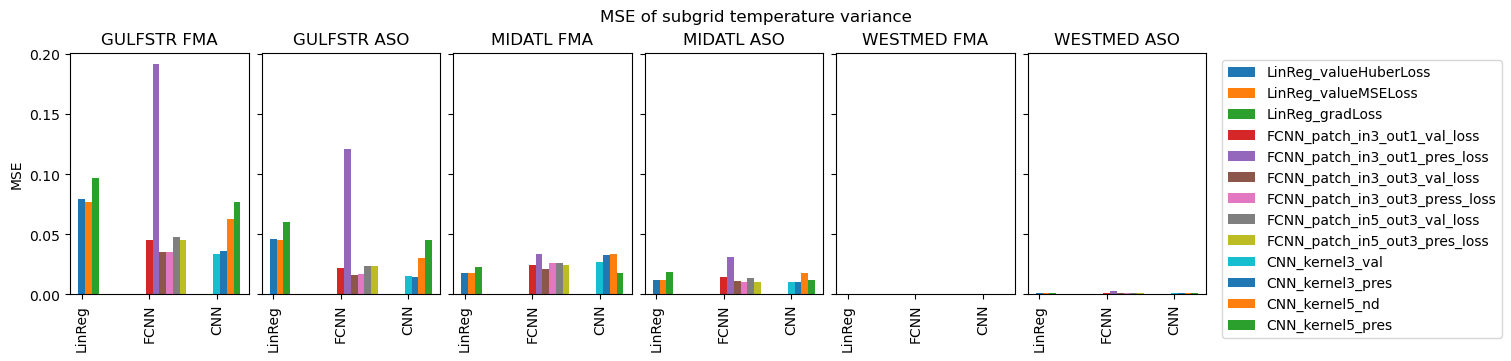

In [56]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3.5), sharex=True, sharey=True)
fig.suptitle('MSE of subgrid temperature variance')

feature = 'votemper_var'
metrics = 'loss_val'
for region in range(len(data_dict)) :
    versions = [0 for i in x]
    for idx_model, model in enumerate(list_of_models) :
        i = xlabels.index(model['model_name'])
        j = versions[i]
        ax[region].bar(x[i]+j*bar_width, model[feature][metrics][region], width=bar_width, label=model['label'])
        versions[i]+=1
    ax[region].set_xticks(x, xlabels, rotation='vertical')
    ax[region].set(title=data_dict[region]['label'])
ax[0].set(ylabel='MSE')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()